In [3]:
# Install dependencies
%pip install -r requirements.txt

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from mrp import RiverSwim, MdpPi
from mc import p2n
from estimate import exact, co_loop, co_loop_single, co_model_based, co_td_k

In [7]:
# RiverSwim MDP
rs = RiverSwim()
# Follow the "always swim upstream" policy
pi = [1] * 6
# Use the induced MRP
mrp = MdpPi(rs, pi)

In [8]:
# MRP parameters
mrp.p

array([[0.7, 0.3, 0. , 0. , 0. , 0. ],
       [0.1, 0.6, 0.3, 0. , 0. , 0. ],
       [0. , 0.1, 0.6, 0.3, 0. , 0. ],
       [0. , 0. , 0.1, 0.6, 0.3, 0. ],
       [0. , 0. , 0. , 0.1, 0.6, 0.3],
       [0. , 0. , 0. , 0. , 0.7, 0.3]])

In [9]:
mrp.r

array([0., 0., 0., 0., 0., 1.])

In [11]:
# Solve for expected first return times from state i to state j
fr = p2n(mrp.p)
fr

array([[155.71428571,   3.33333333,   7.77777778,  12.59259259,
         17.5308642 ,  22.51028807],
       [515.71428571,  51.9047619 ,   4.44444444,   9.25925926,
         14.19753086,  19.17695473],
       [684.28571429, 168.57142857,  17.3015873 ,   4.81481481,
          9.75308642,  14.73251029],
       [737.14285714, 221.42857143,  52.85714286,   5.76719577,
          4.9382716 ,   9.91769547],
       [751.42857143, 235.71428571,  67.14285714,  14.28571429,
          1.92239859,   4.97942387],
       [752.85714286, 237.14285714,  68.57142857,  15.71428571,
          1.42857143,   4.48559671]])

In [12]:
# Expected recurrence times
rho = fr.diagonal()
rho

array([155.71428571,  51.9047619 ,  17.3015873 ,   5.76719577,
         1.92239859,   4.48559671])

In [13]:
# Maximal expected hitting times
tau = fr.max(0)
tau

array([752.85714286, 237.14285714,  68.57142857,  15.71428571,
        17.5308642 ,  22.51028807])

In [15]:
# Discount factor for value, gamma
discount = 0.9
# Solve for state values exactly
v = exact(mrp.p, mrp.r, discount)
v

array([0.51032133, 0.69932923, 1.02134269, 1.50695559, 2.22695825,
       3.29175849])

In [16]:
# Experiment setting (Takes about an hour on a workstation)
n_sample_paths = 200
n_chunks = 100
len_chunk = 1000
initial_state = 0
discount = 0.99
v = exact(mrp.p, mrp.r, discount)

# Log estimates
vs_loop = zeros((n_sample_paths, n_chunks, mrp.n_states))
vs_mb = zeros((n_sample_paths, n_chunks, mrp.n_states))
vs_td = zeros((n_sample_paths, n_chunks, mrp.n_states))
vs_td_10 = zeros((n_sample_paths, n_chunks, mrp.n_states))
vs_td_em = zeros((n_sample_paths, n_chunks, mrp.n_states))

for i in range(n_sample_paths):
    # Reset the MRP to initial state
    mrp.state = initial_state

    # Estimators
    # Loop estimator
    v_loop = co_loop(mrp.n_states, discount)
    v_loop.send(None)
    # Model-based estimator
    v_mb = co_model_based(mrp.n_states, discount)
    v_mb.send(None)
    # TD(0) estimator with linear update sizes (Robbins-Monro condition)
    v_td = co_td_k(0, mrp.n_states, discount, lambda n : 1 / n)
    v_td.send(None)
    # TD(10) estimator [KS00]
    v_td_10 = co_td_k(10, mrp.n_states, discount, lambda n : 1 / n)
    v_td_10.send(None)
    # TD(0) estimator with polynomial update sizes [EM03]
    v_td_em = co_td_k(0, mrp.n_states, discount, lambda n : 1 / n ** 0.5)
    v_td_em.send(None)

    for j in range(n_chunks):
        # Sample some steps
        chunk = list(mrp.sample_transition(len_chunk))
        # Update estimates
        v_loop_hat = v_loop.send(chunk)
        v_mb_hat = v_mb.send(chunk)
        v_td_hat = v_td.send(chunk)
        v_td_10_hat = v_td_10.send(chunk)
        v_td_em_hat = v_td_em.send(chunk)
        # Record estimates
        vs_loop[i, j] = v_loop_hat
        vs_mb[i, j] = v_mb_hat
        vs_td[i, j] = v_td_hat
        vs_td_10[i, j] = v_td_10_hat
        vs_td_em[i, j] = v_td_em_hat

In [18]:
# Optionally save them to disk
save('vs_loop_%i_%.4f' % (n_sample_paths, discount), vs_loop)
save('vs_mb_%i_%.4f' % (n_sample_paths, discount), vs_mb)
save('vs_td_%i_%.4f' % (n_sample_paths, discount), vs_td)
save('vs_td_10_%i_%.4f' % (n_sample_paths, discount), vs_td_10)
save('vs_td_em_%i_%.4f' % (n_sample_paths, discount), vs_td_em)

In [22]:
# Optionally load them from disk
vs_loop = load('vs_loop_200_0.9900.npy')
vs_mb = load('vs_mb_200_0.9900.npy')
vs_td = load('vs_td_200_0.9900.npy')
vs_td_10 = load('vs_td_10_200_0.9900.npy')
vs_td_em = load('vs_td_em_200_0.9900.npy')

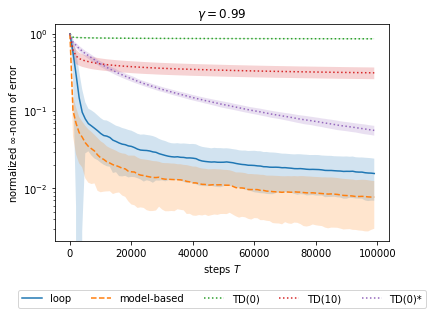

In [24]:
# Plot normalized estimation error (in inf-norm) over steps
legends = ['loop', 'model-based', 'TD(0)', 'TD(10)', 'TD(0)*']
lss = ['-', '--', ':', ':', ':']
vss = [vs_loop, vs_mb, vs_td, vs_td_10, vs_td_em]
# Use max_s v(s) as a scale for errors
max_v = v.max()

for label, vs, ls in zip(legends, vss, lss):
    # Plot the estimation errors with standard deviations
    dd = np.abs(vs - v.reshape((1, 1, -1))).max(2)
    # Normalize errors by max_s v(s)
    dd /= max_v
    dmean = dd.mean(0)
    derr = dd.std(0)
    steps = arange(0, n_chunks * len_chunk, len_chunk)
    plot(steps, dmean, ls, label=label)
    fill_between(steps, dmean - derr, dmean + derr, alpha=0.2)
yscale('log')

ylabel(r'normalized $\infty$-norm of error')
xlabel(r'steps $T$')
title(r'$\gamma=%.2f$' % discount)

lgd = legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(legends))
savefig('inf-error-200-99.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

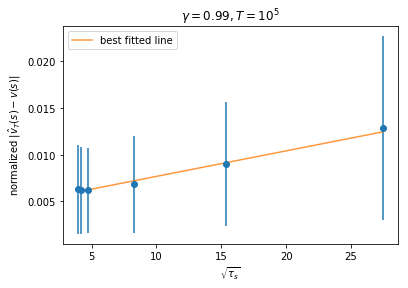

In [48]:
# Assess the scaling of error over tau_s
from numpy.polynomial.polynomial import polyfit

# Plot the estimation errors with standard deviations over states
dd = np.abs(vs_loop - v.reshape((1, 1, -1)))[:, -1, :]
dd /= max_v
dmean = dd.mean(0)
derr = dd.std(0)
steps = arange(0, n_chunks * len_chunk, len_chunk)
# Fit a line
xx = sqrt(tau)
b, m = polyfit(xx, dmean, deg=1, w=1 / derr)
errorbar(xx, dmean, yerr=derr, fmt='o', label=None, alpha=1)
plot(xx, b + m * xx, '-', alpha=0.8, label='best fitted line')

legend(loc='upper left')
xlabel(r'$\sqrt{\tau_s}$')
ylabel(r'normalized $| \hat{v}_T(s) - v(s) |$')
title(r'$\gamma = %.2f, T = 10^5$' % discount)
savefig('tau-delta-200-99.pdf')

Text(0.5, 1.0, '$\\gamma = 0.99, T = 10^5$')

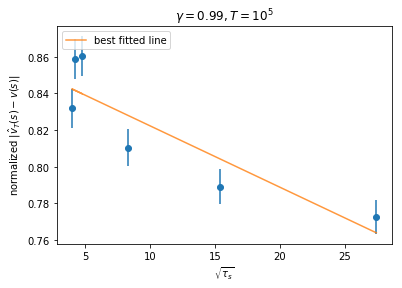

In [47]:
# Assess the scaling of error over tau_s for an alternative method, TD(0)
# Plot the estimation errors with standard deviations over states
dd = np.abs(vs_td - v.reshape((1, 1, -1)))[:, -1, :]
dd /= max_v
dmean = dd.mean(0)
derr = dd.std(0)
steps = arange(0, n_chunks * len_chunk, len_chunk)
# Fit a line
xx = sqrt(tau)
b, m = polyfit(xx, dmean, deg=1, w=1 / derr)
errorbar(xx, dmean, yerr=derr, fmt='o', label=None, alpha=1)
plot(xx, b + m * xx, '-', alpha=0.8, label='best fitted line')

legend(loc='upper left')
xlabel(r'$\sqrt{\tau_s}$')
ylabel(r'normalized $| \hat{v}_T(s) - v(s) |$')
title(r'$\gamma = %.2f, T = 10^5$' % discount)